In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [11]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

x = {}
x_array_read = np.load("x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [ ]:
# x_vals_all = np.load("x_vals_all.npy")
# y_vals_all = np.load("y_vals_all.npy")

In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [2]:
model_all_BCE = tf.keras.models.load_model("model_all_BCE_3_4096")
model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

2023-10-23 12:42:36.595913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 12:42:37.265324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 778 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [3]:
def createSimpleModel(weight):
    input_layer = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation="relu",
                         kernel_initializer=tf.keras.initializers.Constant(weight))(input_layer)
    model = Model(inputs=input_layer, outputs=simple_model)
    return model

4 Features 2 Parameter Semi Weakly Supervised Model

In [33]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

test_list = []

epsilon = 1e-6

sig_space = np.logspace(-3, -1, 20)
for sigfrac in sig_space:
    print("Signal Fraction: ", sigfrac)
    for l in model_all_MSE.layers:
        l.trainable=False

    model3 = createSimpleModel(2)
    model32 = createSimpleModel(3)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all_MSE(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1 + sigfrac*LLR
    #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
    ws = LLR_xs / (1.+ LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 4.5
    m2 = 6

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
    print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

    scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
#     plt.plot(tpr,tpr/np.sqrt(fpr + epsilon))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2 + epsilon))
    
#     max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
#     max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

Signal Fraction:  0.001
30232 90698 30 0.0009923260121725325
Epoch 1/20
30/30 [==============================] - 1s 12ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/20
30/30 [==============================] - 0s 

KeyboardInterrupt: 

(0.0, 700.0)

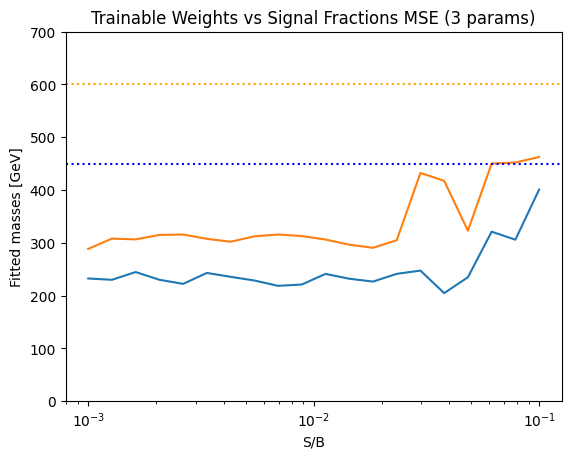

In [32]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (3 params)")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

Text(0.5, 1.0, 'S/B vs Fitted S/B')

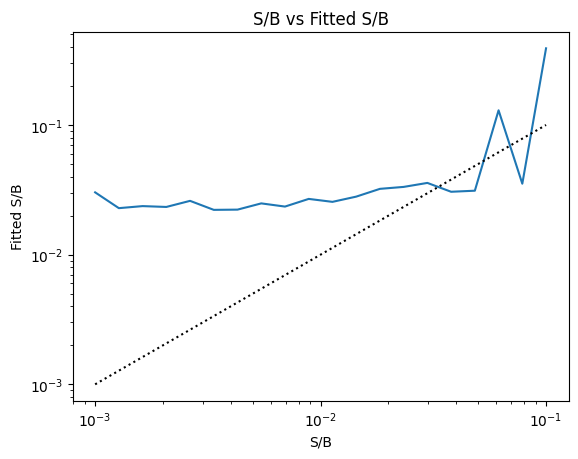

In [19]:
plt.plot(sig_list,np.array(w3_list))
plt.xscale("log")
plt.yscale("log")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")
plt.title("S/B vs Fitted S/B")

In [ ]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

test_list = []

epsilon = 1e-6

sig_space = np.logspace(-3, -1, 20)
print(sigfrac)
#for sigfrac in sig_space:
    #print("Signal Fraction: ", sigfrac)
for l in model_all_MSE.layers:
    l.trainable=False

model3 = createSimpleModel(3)
model32 = createSimpleModel(5)

inputs_hold3 = tf.keras.Input(shape=(1,))
simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

inputs = tf.keras.Input(shape=(4,))
inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all_MSE(inputs2)
LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
#LLR_xs = 1 + sigfrac*LLR - sigfrac
LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
ws = LLR_xs / (1.+ LLR_xs)
model_all2 = Model(inputs = inputs, outputs = ws)
model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

m1 = 4.5
m2 = 6

test_background = int(1/2 *len(x[0,0]))
train_background = int(1/4 * len(x[0,0]))
train_data = int(1/4 * len(x[0,0]))
train_reference = int(1/4 * len(x[0,0]))
#signal
test_signal_length = int(1/2*len(x[m1,m2]))
N = int(1/4 * (len(x[0,0])))
signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

x_vals_ = np.concatenate([x[0,0][test_background:],signal])
#[reference (1), data_background (0), signal(0)]
y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)

X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

sig_list+=[sigfrac]
w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
#     plt.plot(tpr,tpr/np.sqrt(fpr + epsilon))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2 + epsilon))
    
#     max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
#     max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

In [ ]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (3 params)")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

In [ ]:
plt.plot(sig_list,np.array(w3_list))
plt.xscale("log")
plt.yscale("log")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")
plt.title("S/B vs Fitted S/B")

In [ ]:
plt.plot(sig_list,max_SIC1,label="Weakly, Semisupervised")
plt.plot(sig_list,max_SIC2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")